In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Endothelial/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

FIG2SAVE = DIR2SAVE.joinpath("final/figures/forpaper/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Endothelial_clustering.h5ad"
    )
)
adata.shape

(557, 2000)

In [4]:
adata.obs.Annotation_scVI_detailed.cat.categories

Index(['Lymphatic endo', 'SEC', 'Stalk-like endo', 'Tip-like endo'], dtype='object')

In [5]:
adata.uns["Annotation_scVI_detailed_colors"] = ["#b2df8a",
                                                "#fb9a99",
                                                "#a6cee3",
                                                "#1f78b4"
                                               ]

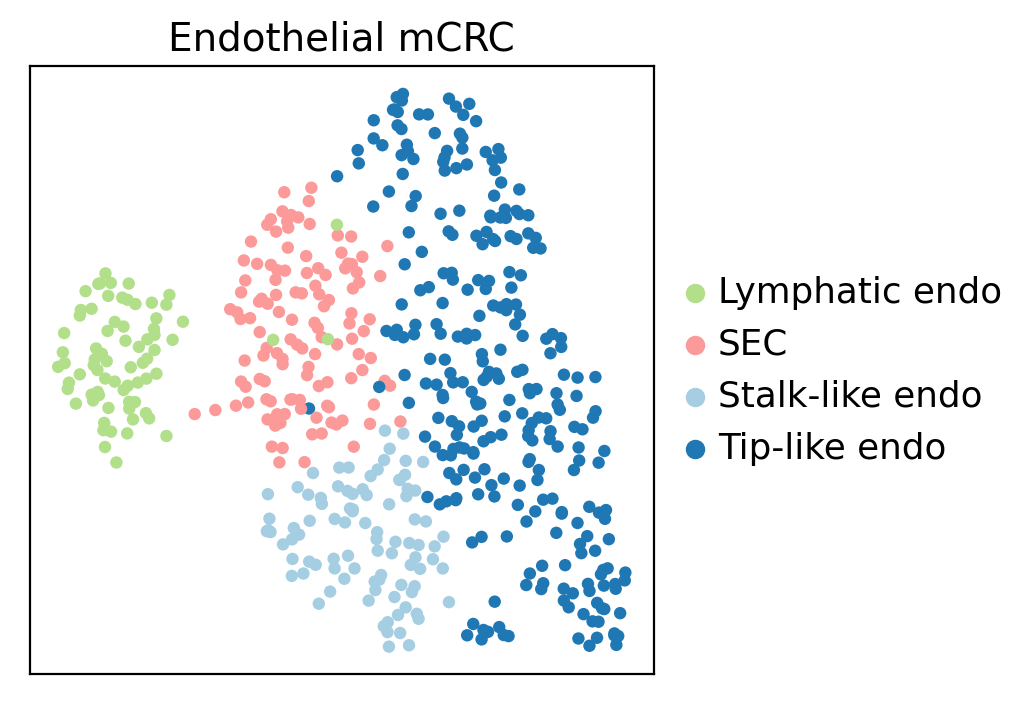

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=False,
    legend_loc="right margin",
    title="Endothelial mCRC",
    size=80,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig(FIG2SAVE.joinpath("Annotation.pdf"), bbox_inches='tight', dpi=DPI)

In [7]:
markers = {
    #"Endo": ["PECAM1", "PLVAP"],
    #"Prolif endo": ["BIRC5", "MKI67"],
    "Lymphatic endo": ["LYVE1", "PROX1"],
    "Stalk": ["ACKR1", "SELP"],
    "Tip": ["RGCC", "KDR"],
    "SEC": ["FCN3", "FCN2", "CLEC4G"],  # 'F8', 'CD9', 'SPARCL1', 'TM4SF1']
    #"Enteric glial": ["S100B", "PLP1"],
    # "Arterial": ["EFNB2"],
}

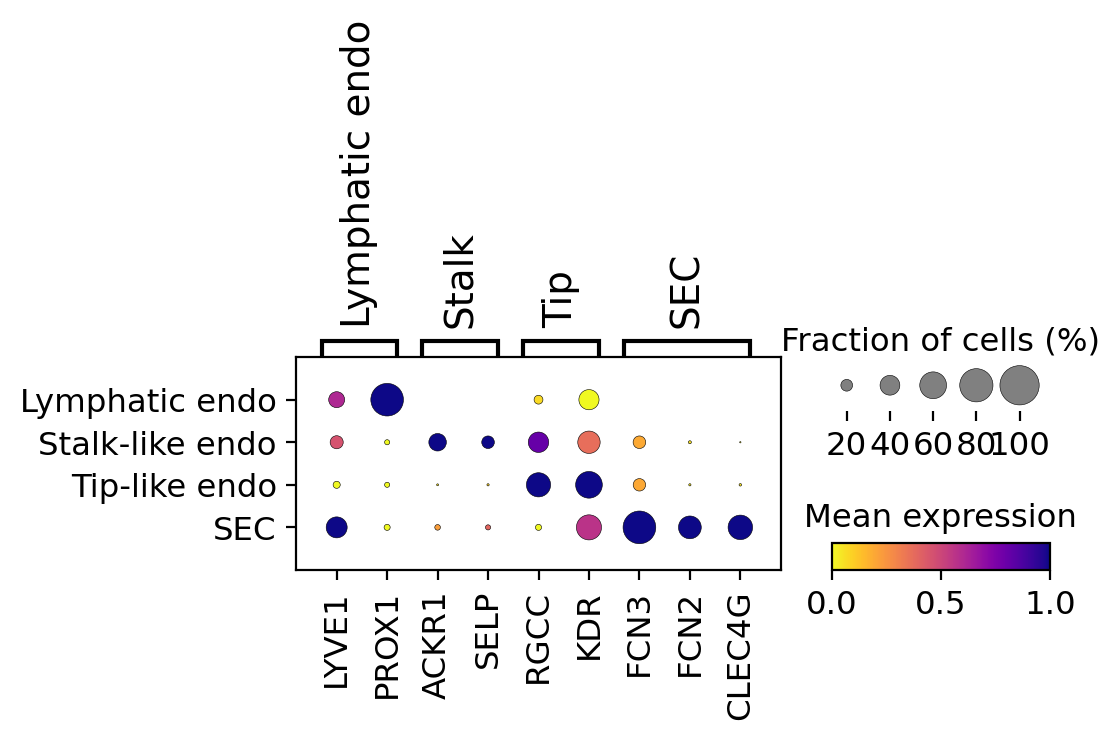

In [8]:
sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers,
    categories_order=["Lymphatic endo", "Stalk-like endo", "Tip-like endo", "SEC"],
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    size_title = "Fraction of cells (%)",
    dot_max=1,
    dendrogram=False,
    save="Endothelial_dotplot_mean_general_annotations.pdf",
    show=True,
)

### zscore

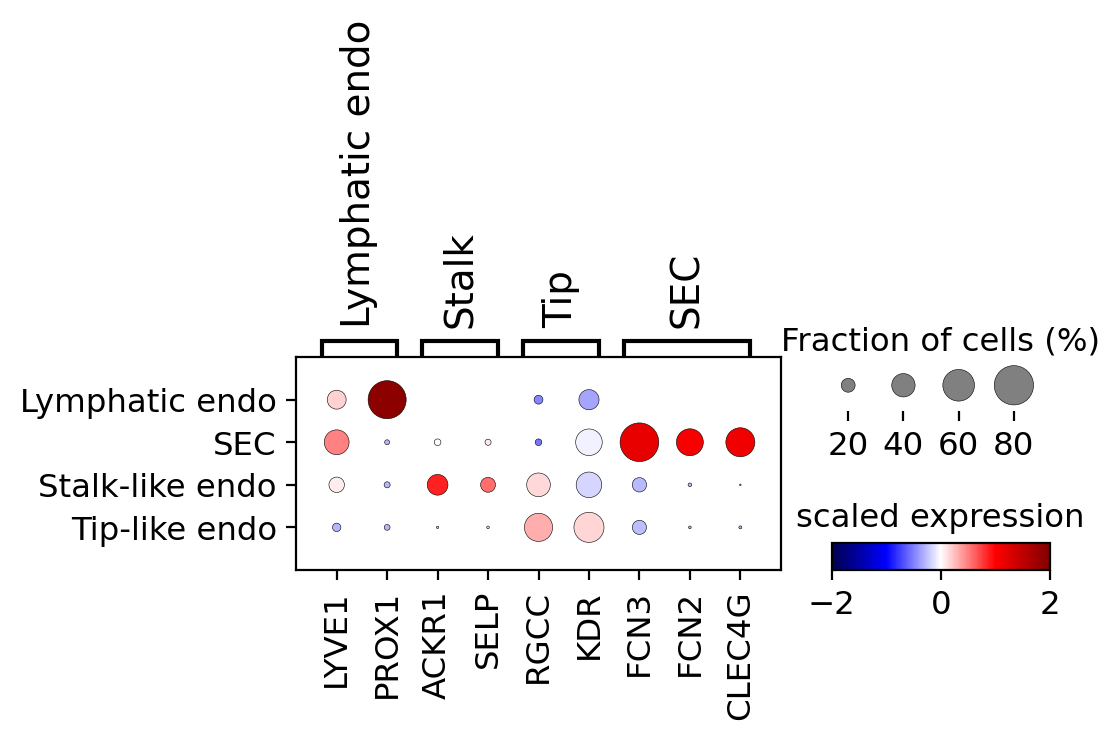

In [9]:
adata_zscore = adata.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore.layers['scaled'] = sc.pp.scale(adata_zscore, copy=True).X
adata_zscore.obs=adata.obs
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers,
              groupby="Annotation_scVI_detailed",
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              #dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save='zscore_general.pdf')

In [10]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.barh(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source               BCI-Nuclei  Che-Cells
Annotation_scVI_detailed                       
Lymphatic endo             84.931507  15.068493
SEC                        94.166667   5.833333
Stalk-like endo            80.219780  19.780220
Tip-like endo              88.278388  11.721612


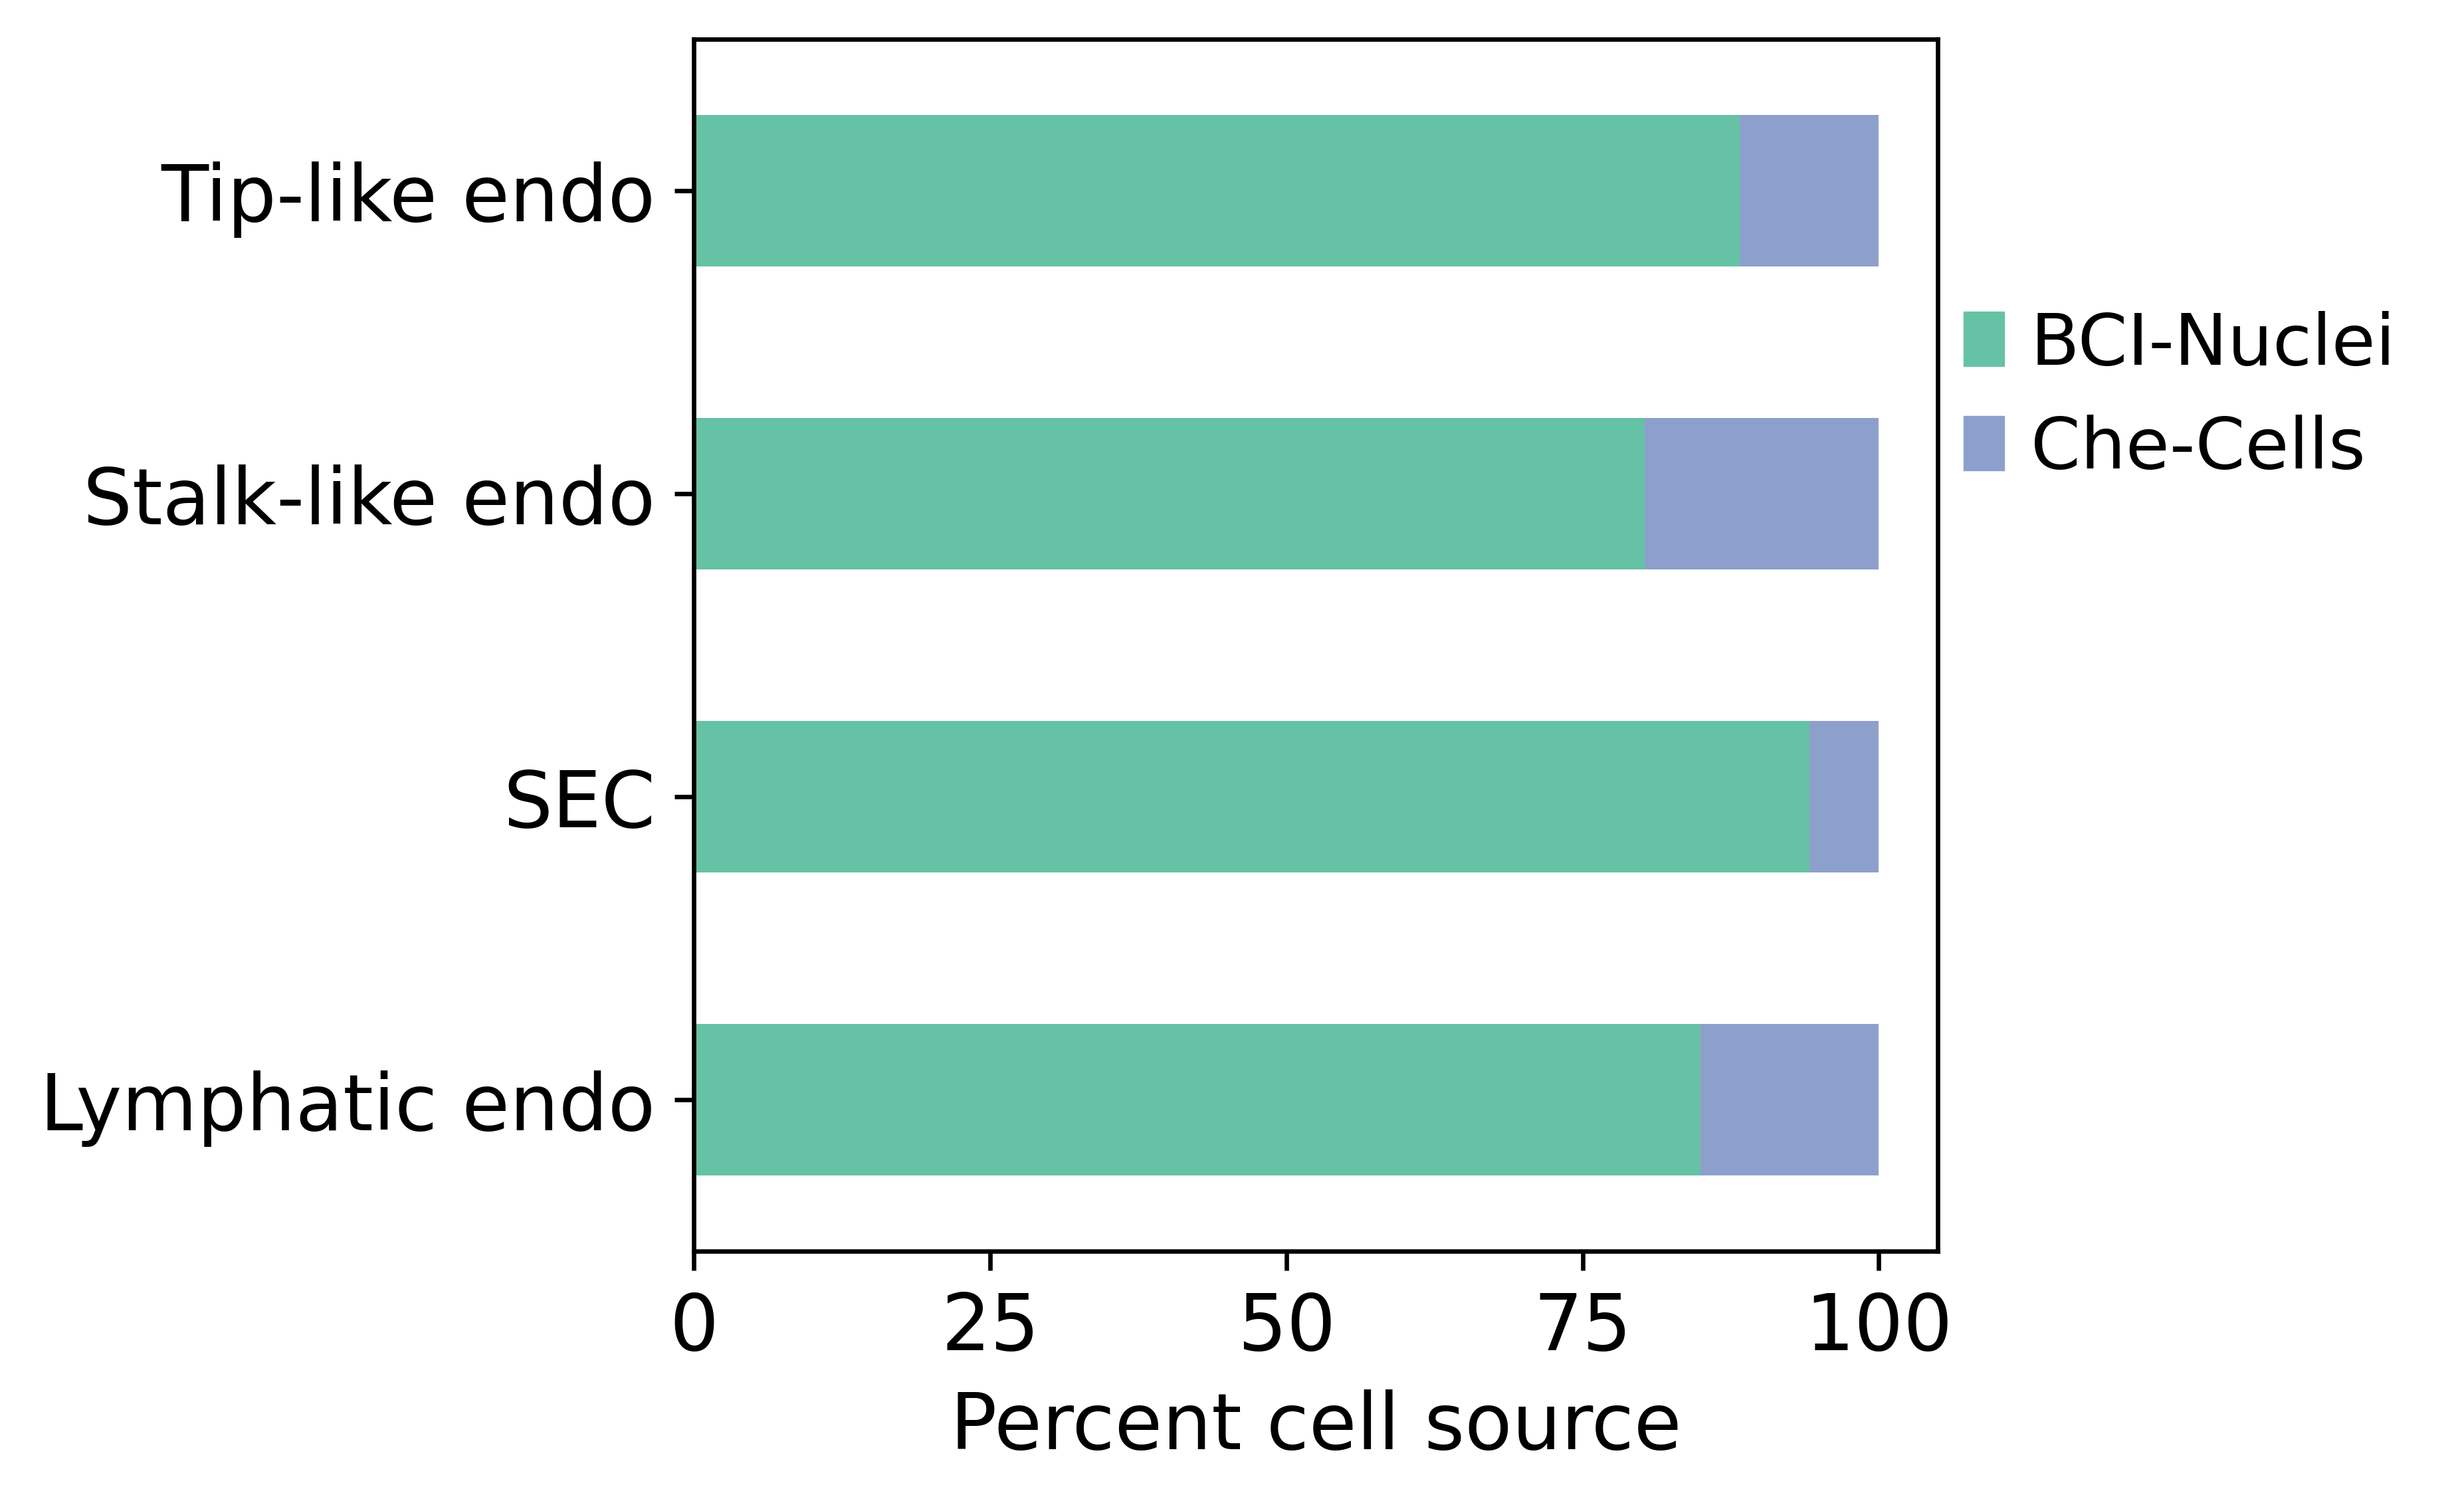

In [11]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI_detailed", "cell_source"],
    xlabel="Percent cell source",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

Annotation_scVI_detailed  Lymphatic endo        SEC  Stalk-like endo  \
cell_source                                                            
BCI-Nuclei                     12.678937  23.108384        14.928425   
Che-Cells                      16.176471  10.294118        26.470588   

Annotation_scVI_detailed  Tip-like endo  
cell_source                              
BCI-Nuclei                    49.284254  
Che-Cells                     47.058824  


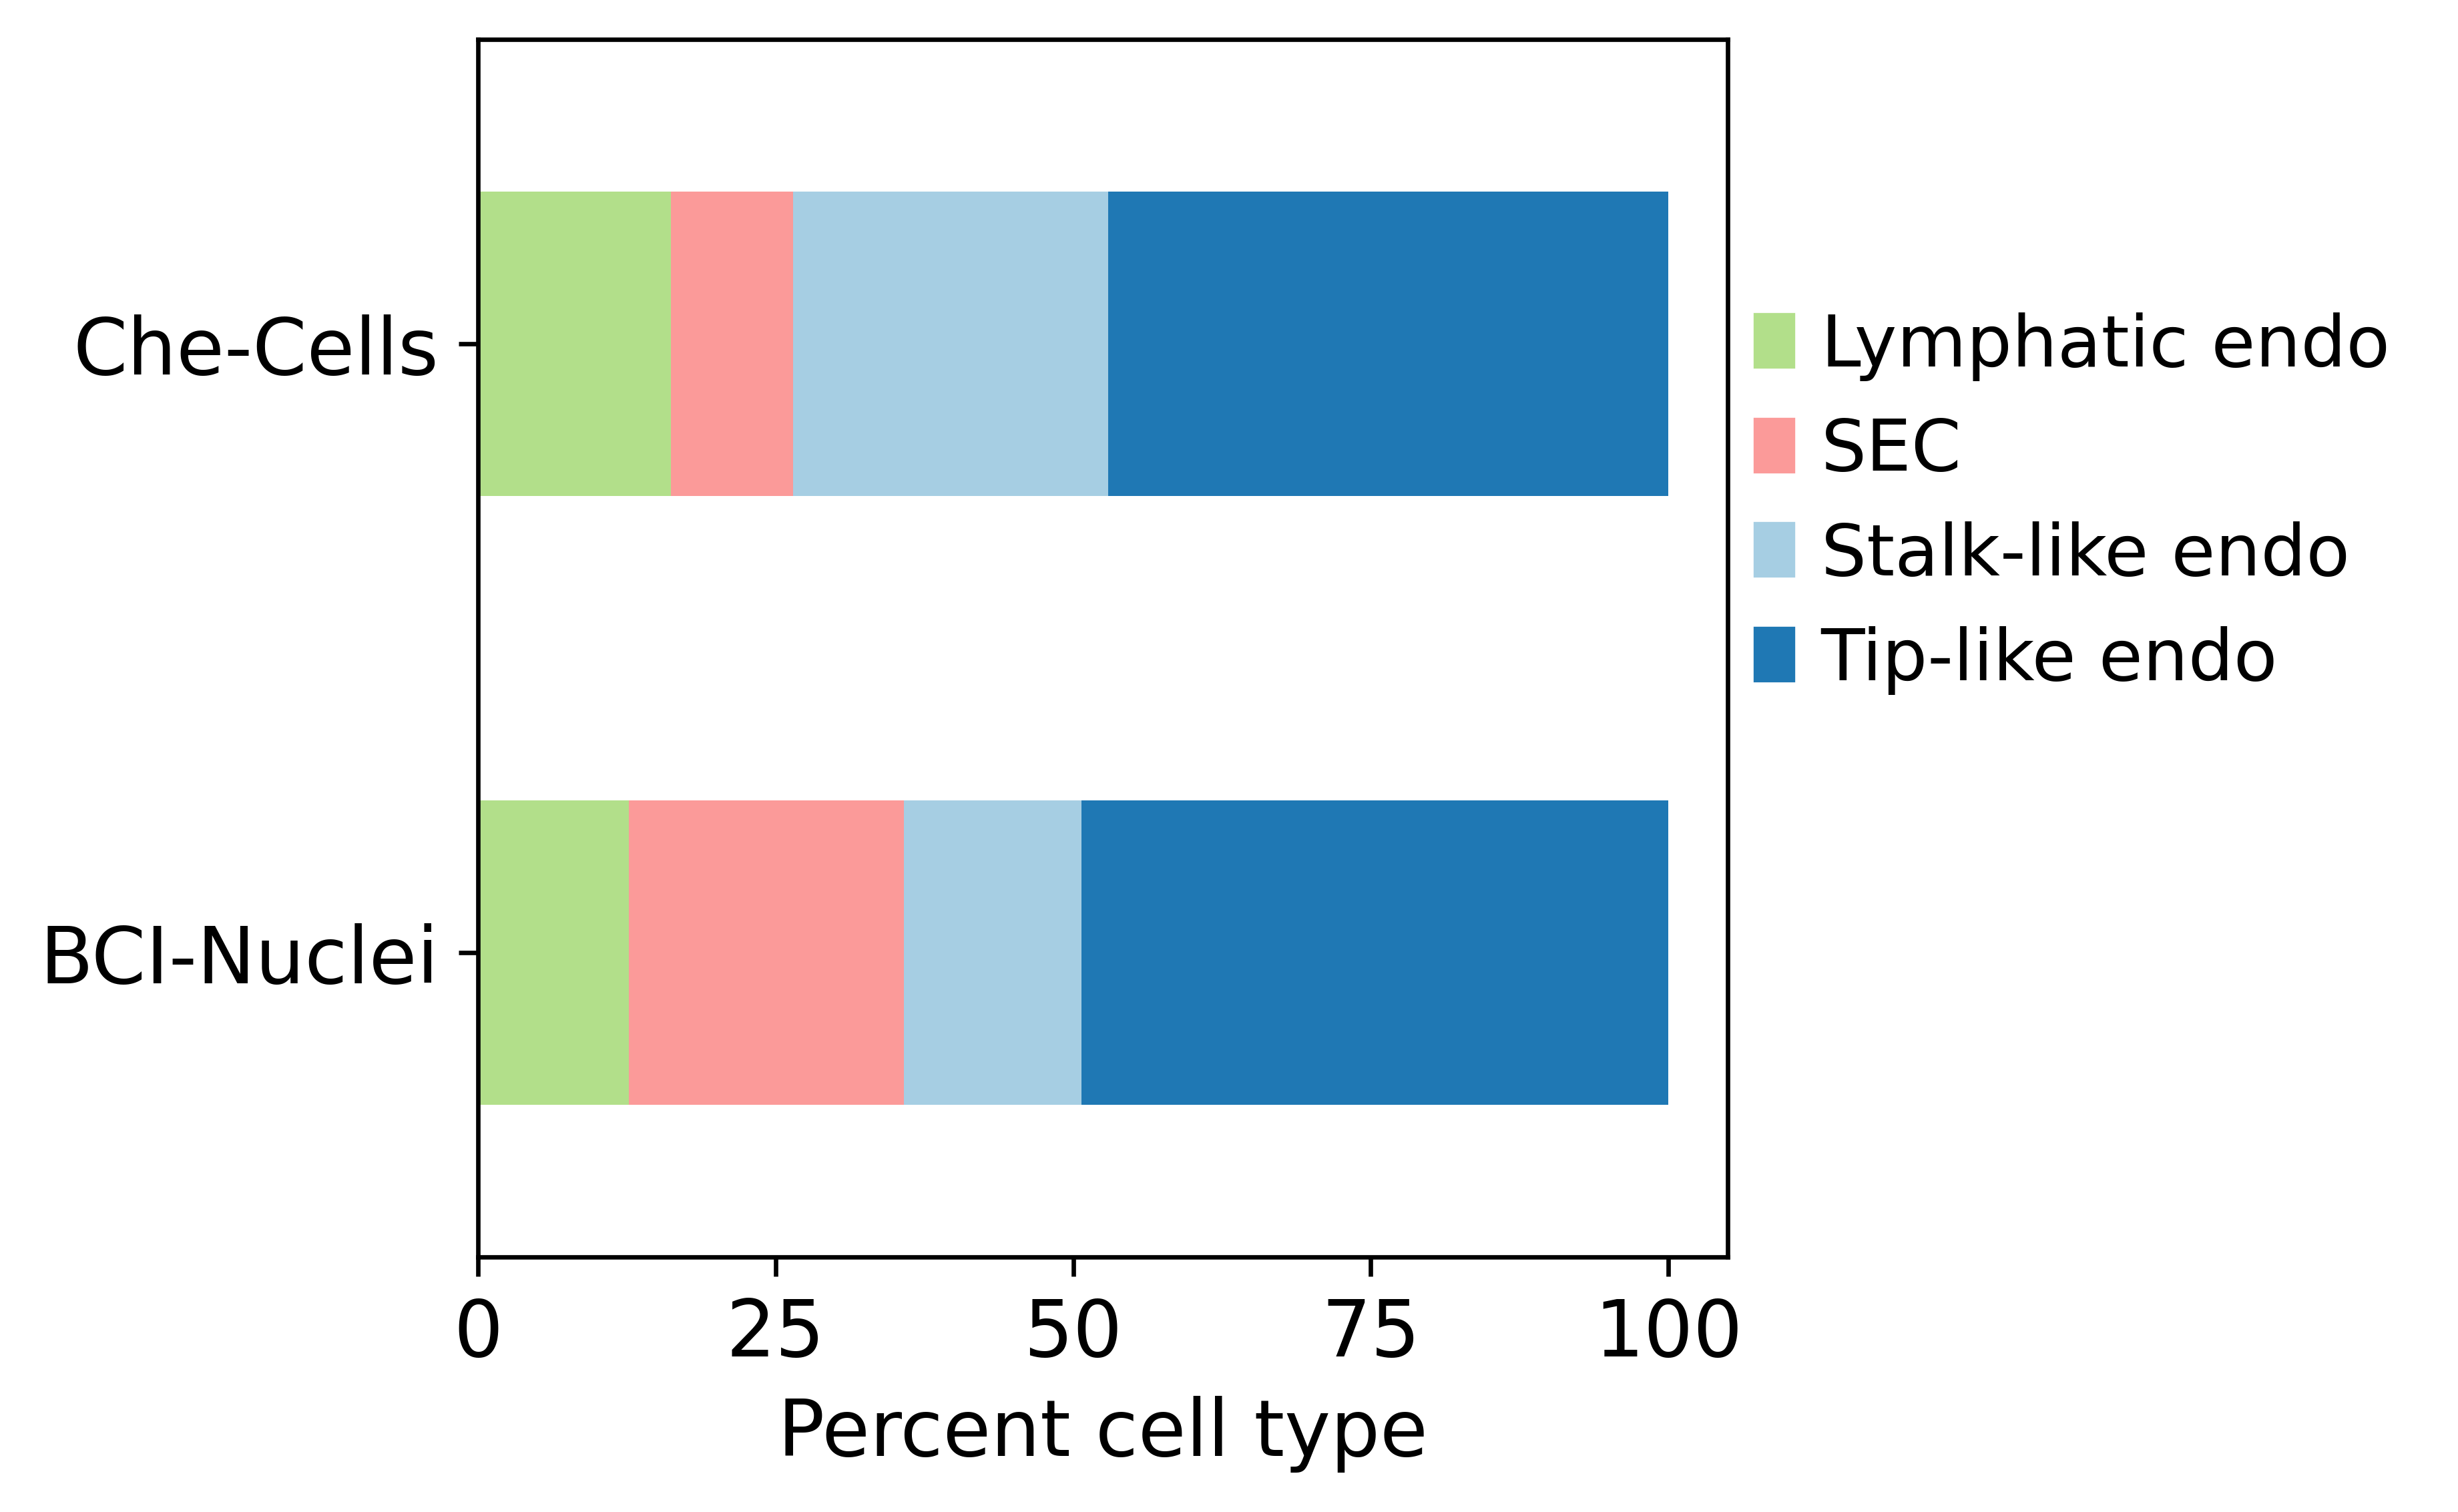

In [12]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI_detailed"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_detailed_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["cell_source", "Annotation_scVI_detailed"],
    xlabel="Percent cell type",
    ylabel="",
    colors=color_dict,
    figname="barplot_annotation_across_cell_source.pdf",
)

**From "A human liver cell atlas reveals heterogeneity and epithelial progenitors, Nature paper":**

> In the normal liver, LSECs line the sinusoids of the liver lobule and are
CLEC4G+PECAM1low
, while MaVECs line the hepatic arteries and veins and are
CD34+PECAM1high cells

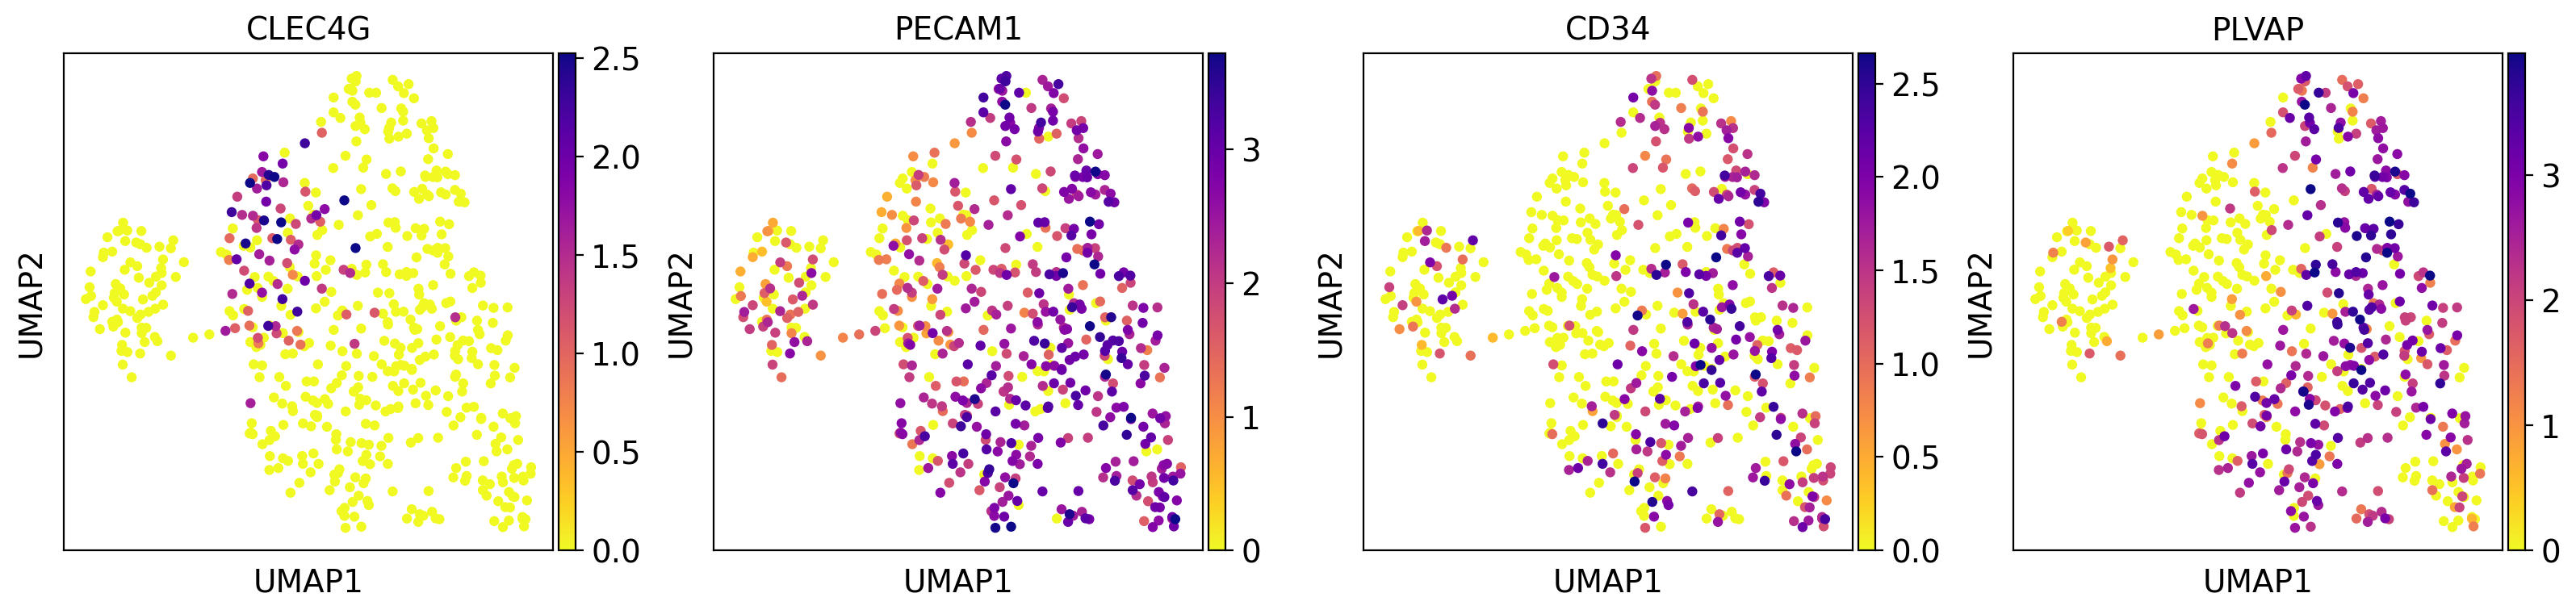

In [13]:
sc.pl.umap(
    adata,
    color=["CLEC4G", "PECAM1", "CD34", "PLVAP"],
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="LSECs_vs_VECs.pdf",
    size=80,
    show=True,
)